In [1]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 32
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [2]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef

import math

import matplotlib.pyplot as plt

In [3]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [5]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

# def pred2label(y_pred):
#     y_pred = np.round(y_pred)
#     return y_pred

def pred2label(y_pred, threshold):
    y_pred = (y_pred >= threshold).astype(int)
    return y_pred

In [7]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 15, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 15,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)
    
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [8]:
# for step in range(10):
#     initial_learning_rate=1e-1
#     decay_steps=10000
#     decay_rate=0.9
#     print(step, ':', initial_learning_rate * decay_rate ** (step / decay_steps))

In [9]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 15)       3165        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 15)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 15)       0           ['activation[0][0]']             
                                                                                              

# Training

In [10]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

features = np.array(list(train_data['OHE_Sequence']))
labels = np.array(list(train_data['label']))
labels = labels.reshape((labels.shape[0], 1))

input_seq_shape = features[0].shape

folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

In [11]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

    
train_history = []

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    h = model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], 
                  batch_size = batch_size, epochs = epochs, 
                  verbose = 1, callbacks = modelCallbacks, 
                  validation_data = (fold["X_test"], fold["y_test"]))
    
    train_history.append(h)
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    threshold = thresholds[np.argmax(tpr + (1 - fpr))]
    
    label_pred = pred2label(y_pred, threshold)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)
    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
#     fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
#     auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred, threshold)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.4777
Epoch 1: val_loss improved from inf to 0.99846, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold0.hdf5
60/60 [==============================] - 5s 19ms/step - loss: 1.0550 - accuracy: 0.4777 - val_loss: 0.9985 - val_accuracy: 0.5681
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.5218
Epoch 2: val_loss improved from 0.99846 to 0.94847, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold0.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.9852 - accuracy: 0.5218 - val_loss: 0.9485 - val_accuracy: 0.5346
Epoch 3/100
55/60 [==========================>...] - ETA: 0s - loss: 0.9328 - accuracy: 0.5653
Epoch 3: val_loss improved from 0.94847 to 0.87992, saving model to

57/60 [===========================>..] - ETA: 0s - loss: 0.5417 - accuracy: 0.7873
Epoch 21: val_loss improved from 0.56730 to 0.55806, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold0.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5391 - accuracy: 0.7890 - val_loss: 0.5581 - val_accuracy: 0.7694
Epoch 22/100
55/60 [==========================>...] - ETA: 0s - loss: 0.5140 - accuracy: 0.7989
Epoch 22: val_loss improved from 0.55806 to 0.55143, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold0.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5156 - accuracy: 0.7979 - val_loss: 0.5514 - val_accuracy: 0.7778
Epoch 23/100
57/60 [===========================>..] - ETA: 0s - loss: 0.5118 - accuracy: 0.7950
Epoch 23: val_loss did not improve from 0.55143
60/60 [==============================] - 1s 11ms/step

Epoch 46/100
58/60 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.8378
Epoch 46: val_loss did not improve from 0.49805
60/60 [==============================] - 1s 9ms/step - loss: 0.4191 - accuracy: 0.8362 - val_loss: 0.5034 - val_accuracy: 0.8008
Epoch 47/100
58/60 [============================>.] - ETA: 0s - loss: 0.4156 - accuracy: 0.8400
Epoch 47: val_loss did not improve from 0.49805
60/60 [==============================] - 1s 9ms/step - loss: 0.4154 - accuracy: 0.8399 - val_loss: 0.5061 - val_accuracy: 0.7862
Epoch 48/100
58/60 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8518
Epoch 48: val_loss did not improve from 0.49805
60/60 [==============================] - 1s 8ms/step - loss: 0.3993 - accuracy: 0.8535 - val_loss: 0.5035 - val_accuracy: 0.7987
Epoch 49/100
58/60 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8432
Epoch 49: val_loss improved from 0.49805 to 0.49506, saving model to Results\NT_Site_

Epoch 75/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3610 - accuracy: 0.8783
Epoch 75: val_loss did not improve from 0.48595
60/60 [==============================] - 1s 9ms/step - loss: 0.3661 - accuracy: 0.8756 - val_loss: 0.5280 - val_accuracy: 0.7925
Epoch 76/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3737 - accuracy: 0.8684
Epoch 76: val_loss did not improve from 0.48595
60/60 [==============================] - 1s 9ms/step - loss: 0.3742 - accuracy: 0.8672 - val_loss: 0.4965 - val_accuracy: 0.7945
Epoch 77/100
58/60 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8664
Epoch 77: val_loss did not improve from 0.48595
60/60 [==============================] - 1s 9ms/step - loss: 0.3727 - accuracy: 0.8661 - val_loss: 0.5129 - val_accuracy: 0.7778
Epoch 78/100
58/60 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8648
Epoch 78: val_loss did not improve from 0.48595
60/60 [==============================

60/60 [==============================] - 1s 10ms/step - loss: 0.9394 - accuracy: 0.5643 - val_loss: 0.8827 - val_accuracy: 0.6939
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 0.8633 - accuracy: 0.6373
Epoch 4: val_loss improved from 0.88272 to 0.79195, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.8633 - accuracy: 0.6373 - val_loss: 0.7919 - val_accuracy: 0.7086
Epoch 5/100
57/60 [===========================>..] - ETA: 0s - loss: 0.7863 - accuracy: 0.6930
Epoch 5: val_loss improved from 0.79195 to 0.74892, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.7860 - accuracy: 0.6924 - val_loss: 0.7489 - val_accuracy: 0.7317
Epoch 6/100
57/60 [===========================>..] - ETA: 

60/60 [==============================] - 1s 10ms/step - loss: 0.4956 - accuracy: 0.8068 - val_loss: 0.5624 - val_accuracy: 0.7463
Epoch 25/100
54/60 [==========================>...] - ETA: 0s - loss: 0.4969 - accuracy: 0.8113
Epoch 25: val_loss improved from 0.56245 to 0.55806, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.4985 - accuracy: 0.8073 - val_loss: 0.5581 - val_accuracy: 0.7589
Epoch 26/100
54/60 [==========================>...] - ETA: 0s - loss: 0.4998 - accuracy: 0.8067
Epoch 26: val_loss improved from 0.55806 to 0.55751, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5004 - accuracy: 0.8084 - val_loss: 0.5575 - val_accuracy: 0.7568
Epoch 27/100
56/60 [===========================>..] - 

Epoch 48/100
57/60 [===========================>..] - ETA: 0s - loss: 0.4012 - accuracy: 0.8438
Epoch 48: val_loss did not improve from 0.51329
60/60 [==============================] - 1s 9ms/step - loss: 0.4050 - accuracy: 0.8404 - val_loss: 0.5139 - val_accuracy: 0.7715
Epoch 49/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3901 - accuracy: 0.8514
Epoch 49: val_loss improved from 0.51329 to 0.51110, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.3958 - accuracy: 0.8488 - val_loss: 0.5111 - val_accuracy: 0.7757
Epoch 50/100
57/60 [===========================>..] - ETA: 0s - loss: 0.4080 - accuracy: 0.8438
Epoch 50: val_loss did not improve from 0.51110
60/60 [==============================] - 1s 9ms/step - loss: 0.4082 - accuracy: 0.8441 - val_loss: 0.5119 - val_accuracy: 0.7715
Epoch 51/100
57/60 [==========================

56/60 [===========================>..] - ETA: 0s - loss: 0.3632 - accuracy: 0.8616
Epoch 76: val_loss improved from 0.50544 to 0.50487, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold1.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.3657 - accuracy: 0.8619 - val_loss: 0.5049 - val_accuracy: 0.7904
Epoch 77/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3478 - accuracy: 0.8734
Epoch 77: val_loss did not improve from 0.50487
60/60 [==============================] - 1s 9ms/step - loss: 0.3494 - accuracy: 0.8724 - val_loss: 0.5056 - val_accuracy: 0.8050
Epoch 78/100
57/60 [===========================>..] - ETA: 0s - loss: 0.3446 - accuracy: 0.8783
Epoch 78: val_loss did not improve from 0.50487
60/60 [==============================] - 1s 9ms/step - loss: 0.3410 - accuracy: 0.8808 - val_loss: 0.5258 - val_accuracy: 0.7904
Epoch 79/100
59/60 [============================>.] - ETA: 

60/60 [==============================] - 1s 9ms/step - loss: 0.9389 - accuracy: 0.5551 - val_loss: 0.8870 - val_accuracy: 0.6828
Epoch 4/100
59/60 [============================>.] - ETA: 0s - loss: 0.8665 - accuracy: 0.6308
Epoch 4: val_loss improved from 0.88697 to 0.78649, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 9ms/step - loss: 0.8659 - accuracy: 0.6312 - val_loss: 0.7865 - val_accuracy: 0.7311
Epoch 5/100
57/60 [===========================>..] - ETA: 0s - loss: 0.8046 - accuracy: 0.6765
Epoch 5: val_loss improved from 0.78649 to 0.73694, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.8008 - accuracy: 0.6800 - val_loss: 0.7369 - val_accuracy: 0.7395
Epoch 6/100
57/60 [===========================>..] - ETA: 0s

Epoch 24/100
60/60 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.8006
Epoch 24: val_loss improved from 0.52093 to 0.51657, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5008 - accuracy: 0.8006 - val_loss: 0.5166 - val_accuracy: 0.7899
Epoch 25/100
55/60 [==========================>...] - ETA: 0s - loss: 0.5067 - accuracy: 0.7915
Epoch 25: val_loss improved from 0.51657 to 0.51331, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5052 - accuracy: 0.7954 - val_loss: 0.5133 - val_accuracy: 0.7983
Epoch 26/100
54/60 [==========================>...] - ETA: 0s - loss: 0.5028 - accuracy: 0.7963
Epoch 26: val_loss did not improve from 0.51331
60/60 [==============================] -

Epoch 48/100
60/60 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8426
Epoch 48: val_loss improved from 0.46792 to 0.46316, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.4040 - accuracy: 0.8426 - val_loss: 0.4632 - val_accuracy: 0.8067
Epoch 49/100
54/60 [==========================>...] - ETA: 0s - loss: 0.3945 - accuracy: 0.8478
Epoch 49: val_loss did not improve from 0.46316
60/60 [==============================] - 1s 9ms/step - loss: 0.3991 - accuracy: 0.8452 - val_loss: 0.4639 - val_accuracy: 0.8067
Epoch 50/100
59/60 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.8623
Epoch 50: val_loss improved from 0.46316 to 0.46200, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 

Epoch 75/100
54/60 [==========================>...] - ETA: 0s - loss: 0.3508 - accuracy: 0.8744
Epoch 75: val_loss did not improve from 0.44733
60/60 [==============================] - 1s 9ms/step - loss: 0.3502 - accuracy: 0.8725 - val_loss: 0.4625 - val_accuracy: 0.8235
Epoch 76/100
54/60 [==========================>...] - ETA: 0s - loss: 0.3664 - accuracy: 0.8594
Epoch 76: val_loss improved from 0.44733 to 0.44437, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold2.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.3629 - accuracy: 0.8594 - val_loss: 0.4444 - val_accuracy: 0.8298
Epoch 77/100
59/60 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8686
Epoch 77: val_loss did not improve from 0.44437
60/60 [==============================] - 1s 9ms/step - loss: 0.3561 - accuracy: 0.8683 - val_loss: 0.4688 - val_accuracy: 0.8235
Epoch 78/100
59/60 [==========================

60/60 [==============================] - 1s 10ms/step - loss: 0.9935 - accuracy: 0.5283 - val_loss: 0.9555 - val_accuracy: 0.6303
Epoch 3/100
55/60 [==========================>...] - ETA: 0s - loss: 0.9466 - accuracy: 0.5659
Epoch 3: val_loss improved from 0.95552 to 0.91279, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.9442 - accuracy: 0.5693 - val_loss: 0.9128 - val_accuracy: 0.5609
Epoch 4/100
58/60 [============================>.] - ETA: 0s - loss: 0.8795 - accuracy: 0.6250
Epoch 4: val_loss improved from 0.91279 to 0.81196, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.8783 - accuracy: 0.6238 - val_loss: 0.8120 - val_accuracy: 0.7311
Epoch 5/100
58/60 [============================>.] - ETA: 

60/60 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7870
Epoch 23: val_loss improved from 0.57197 to 0.56031, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 11ms/step - loss: 0.5248 - accuracy: 0.7870 - val_loss: 0.5603 - val_accuracy: 0.7773
Epoch 24/100
60/60 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.8054
Epoch 24: val_loss improved from 0.56031 to 0.55884, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5118 - accuracy: 0.8054 - val_loss: 0.5588 - val_accuracy: 0.7731
Epoch 25/100
55/60 [==========================>...] - ETA: 0s - loss: 0.4934 - accuracy: 0.8131
Epoch 25: val_loss did not improve from 0.55884
60/60 [==============================] - 1s 9ms/step 

55/60 [==========================>...] - ETA: 0s - loss: 0.4230 - accuracy: 0.8335
Epoch 47: val_loss improved from 0.52042 to 0.51677, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold3.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.4225 - accuracy: 0.8332 - val_loss: 0.5168 - val_accuracy: 0.7878
Epoch 48/100
58/60 [============================>.] - ETA: 0s - loss: 0.4100 - accuracy: 0.8454
Epoch 48: val_loss did not improve from 0.51677
60/60 [==============================] - 1s 10ms/step - loss: 0.4118 - accuracy: 0.8447 - val_loss: 0.5310 - val_accuracy: 0.7899
Epoch 49/100
59/60 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8443
Epoch 49: val_loss did not improve from 0.51677
60/60 [==============================] - 1s 10ms/step - loss: 0.4028 - accuracy: 0.8442 - val_loss: 0.5216 - val_accuracy: 0.7941
Epoch 50/100
60/60 [==============================] - ETA

Epoch 75/100
60/60 [==============================] - ETA: 0s - loss: 0.3797 - accuracy: 0.8573
Epoch 75: val_loss did not improve from 0.50831
60/60 [==============================] - 1s 9ms/step - loss: 0.3797 - accuracy: 0.8573 - val_loss: 0.5161 - val_accuracy: 0.7857
Epoch 76/100
56/60 [===========================>..] - ETA: 0s - loss: 0.3728 - accuracy: 0.8549
Epoch 76: val_loss did not improve from 0.50831
60/60 [==============================] - 1s 9ms/step - loss: 0.3765 - accuracy: 0.8515 - val_loss: 0.5121 - val_accuracy: 0.7878
Epoch 77/100
54/60 [==========================>...] - ETA: 0s - loss: 0.3698 - accuracy: 0.8652
Epoch 77: val_loss did not improve from 0.50831
60/60 [==============================] - 1s 9ms/step - loss: 0.3677 - accuracy: 0.8646 - val_loss: 0.5152 - val_accuracy: 0.7857
Epoch 78/100
59/60 [============================>.] - ETA: 0s - loss: 0.3518 - accuracy: 0.8692
Epoch 78: val_loss did not improve from 0.50831
60/60 [==============================

60/60 [==============================] - 1s 10ms/step - loss: 0.9433 - accuracy: 0.5352 - val_loss: 0.9181 - val_accuracy: 0.5231
Epoch 4/100
59/60 [============================>.] - ETA: 0s - loss: 0.8944 - accuracy: 0.5731
Epoch 4: val_loss improved from 0.91806 to 0.84943, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 11ms/step - loss: 0.8947 - accuracy: 0.5729 - val_loss: 0.8494 - val_accuracy: 0.6849
Epoch 5/100
60/60 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.6469
Epoch 5: val_loss improved from 0.84943 to 0.78212, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.8272 - accuracy: 0.6469 - val_loss: 0.7821 - val_accuracy: 0.7017
Epoch 6/100
54/60 [==========================>...] - ETA: 

56/60 [===========================>..] - ETA: 0s - loss: 0.5066 - accuracy: 0.7941
Epoch 24: val_loss improved from 0.59108 to 0.58310, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.5041 - accuracy: 0.7970 - val_loss: 0.5831 - val_accuracy: 0.7332
Epoch 25/100
55/60 [==========================>...] - ETA: 0s - loss: 0.4913 - accuracy: 0.8074
Epoch 25: val_loss did not improve from 0.58310
60/60 [==============================] - 1s 9ms/step - loss: 0.4879 - accuracy: 0.8111 - val_loss: 0.5840 - val_accuracy: 0.7521
Epoch 26/100
60/60 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7996
Epoch 26: val_loss improved from 0.58310 to 0.58002, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 10ms/step 

Epoch 49/100
54/60 [==========================>...] - ETA: 0s - loss: 0.3951 - accuracy: 0.8588
Epoch 49: val_loss improved from 0.53289 to 0.53271, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.3986 - accuracy: 0.8573 - val_loss: 0.5327 - val_accuracy: 0.7626
Epoch 50/100
60/60 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8499
Epoch 50: val_loss did not improve from 0.53271
60/60 [==============================] - 1s 10ms/step - loss: 0.4046 - accuracy: 0.8499 - val_loss: 0.5493 - val_accuracy: 0.7500
Epoch 51/100
60/60 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8510
Epoch 51: val_loss did not improve from 0.53271
60/60 [==============================] - 1s 10ms/step - loss: 0.3827 - accuracy: 0.8510 - val_loss: 0.5485 - val_accuracy: 0.7521
Epoch 52/100
60/60 [========================

60/60 [==============================] - 1s 10ms/step - loss: 0.3740 - accuracy: 0.8583 - val_loss: 0.5143 - val_accuracy: 0.7815
Epoch 77/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3607 - accuracy: 0.8761
Epoch 77: val_loss did not improve from 0.51433
60/60 [==============================] - 1s 9ms/step - loss: 0.3638 - accuracy: 0.8736 - val_loss: 0.5282 - val_accuracy: 0.7605
Epoch 78/100
59/60 [============================>.] - ETA: 0s - loss: 0.3517 - accuracy: 0.8718
Epoch 78: val_loss improved from 0.51433 to 0.50900, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_threshold\5fold\models\bestModel-fold4.hdf5
60/60 [==============================] - 1s 10ms/step - loss: 0.3506 - accuracy: 0.8725 - val_loss: 0.5090 - val_accuracy: 0.7731
Epoch 79/100
55/60 [==========================>...] - ETA: 0s - loss: 0.3446 - accuracy: 0.8744
Epoch 79: val_loss did not improve from 0.50900
60/60 [==============================] - 1s 9

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


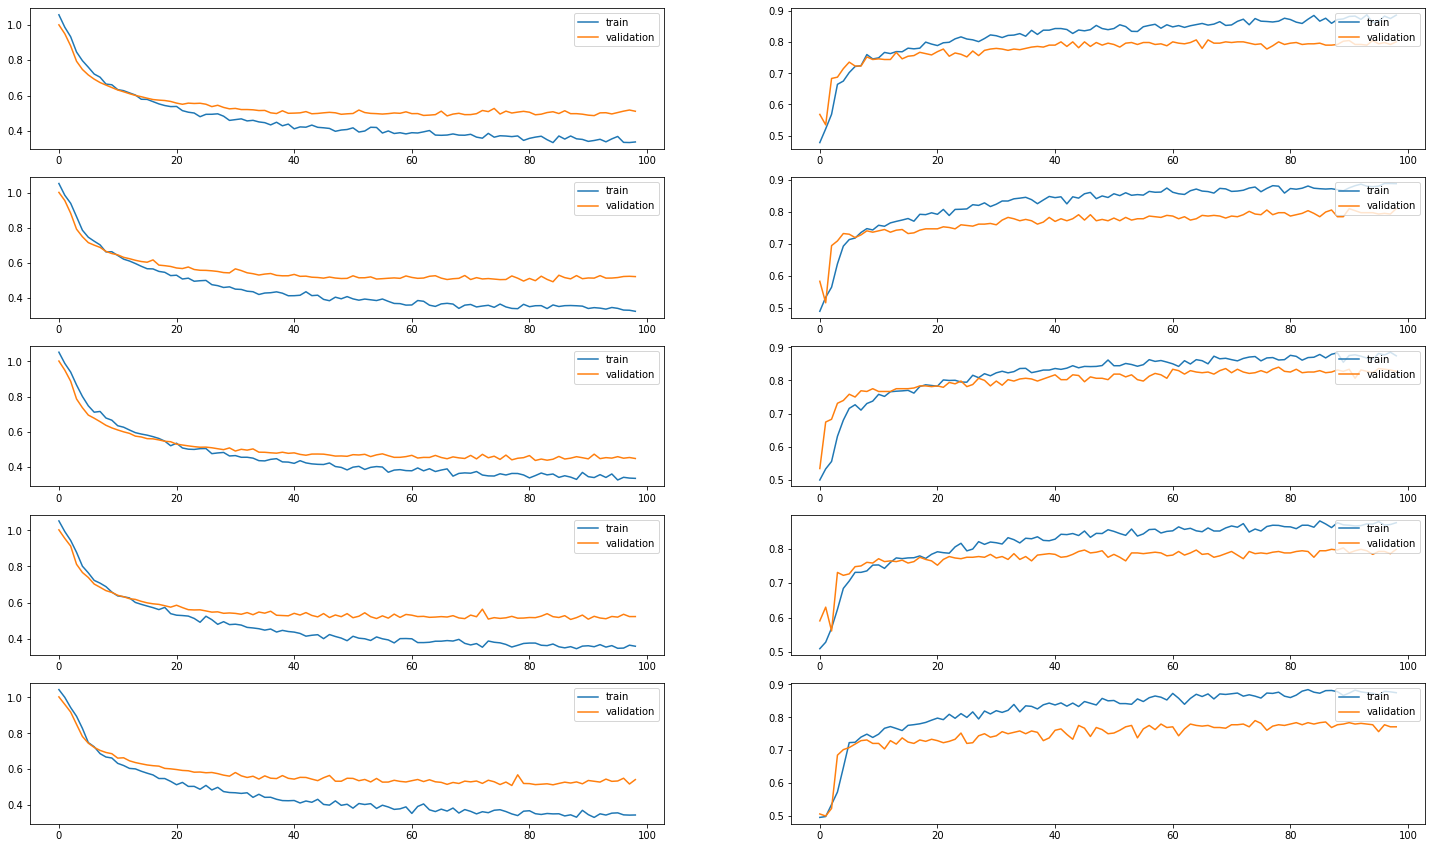

In [12]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(25, 15))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(H.history['loss'][zoom_start:zoom_end])
    axarr[i, 0].plot(H.history['val_loss'][zoom_start:zoom_end])
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 0].show()

    # "accuracy"
    title = 'model accuracy '+str(i)
    axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
    axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].title(title)
#     axarr[i, 1].ylabel('accuracy')
#     axarr[i, 1].xlabel('epoch')
    axarr[i, 1].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 1].show()

## k-fold Training evaluation

In [13]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.803102,0.797871,0.879706,0.812735,0.793446,0.606608
Train,0.954240,0.947659,0.987227,0.961796,0.946686,0.908702


In [14]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.811321,0.792157,"[0.0, 0.0041841004184100415, 0.100418410041841...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9912007, 0.99120075, 0.96720636, 0.96637326...",0.878099,0.845188,0.777311,0.623993
3,1,Test,0.805031,0.800830,"[0.0, 0.004201680672268907, 0.1722689075630252...","[0.0, 0.0, 0.0, 0.008368200836820083, 0.008368...","[1.9968419, 0.9968419, 0.9469619, 0.94026667, ...",0.874363,0.810924,0.799163,0.610120
5,2,Test,0.827731,0.836207,"[0.0, 0.004201680672268907, 0.0462184873949579...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9987245, 0.9987245, 0.9895215, 0.98843354, ...",0.906009,0.815126,0.840336,0.655671
7,3,Test,0.796218,0.794979,"[0.0, 0.004201680672268907, 0.0798319327731092...","[0.0, 0.0, 0.0, 0.008403361344537815, 0.008403...","[1.9975994, 0.9975993, 0.97541827, 0.9748889, ...",0.873738,0.798319,0.794118,0.592442
9,4,Test,0.775210,0.765182,"[0.0, 0.004201680672268907, 0.1974789915966386...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9956756, 0.9956755, 0.9365455, 0.9346548, 0...",0.866323,0.794118,0.756303,0.550814


In [15]:
np.argmax(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])

78

In [16]:
np.max(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])

0.9181532004197271

In [17]:
for i  in range(n_fold):
    print('diff:', 
          np.max(evaluations_df['TPR'][i] - evaluations_df['FPR'][i]),
          'threshold',
          evaluations_df['TPR_FPR_Thresholds'][i][np.argmax(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])]
         )

diff: 0.88872820901708 threshold 0.48424137
diff: 0.6224992088885763 threshold 0.48597
diff: 0.9202088495419154 threshold 0.47254515
diff: 0.6142892303364861 threshold 0.46890745
diff: 0.9181532004197271 threshold 0.5198288


In [18]:
for i  in range(n_fold):
    print('diff:', 
          np.max(evaluations_df['TPR'][i] - evaluations_df['FPR'][i]),
          '\tsum:', 
          np.max(evaluations_df['TPR'][i] + (1-evaluations_df['FPR'][i])),
          '  \tthreshold',
          evaluations_df['TPR_FPR_Thresholds'][i][np.argmax(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])]
         )

diff: 0.88872820901708 	sum: 1.88872820901708   	threshold 0.48424137
diff: 0.6224992088885763 	sum: 1.6224992088885763   	threshold 0.48597
diff: 0.9202088495419154 	sum: 1.9202088495419154   	threshold 0.47254515
diff: 0.6142892303364861 	sum: 1.6142892303364862   	threshold 0.46890745
diff: 0.9181532004197271 	sum: 1.9181532004197273   	threshold 0.5198288


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


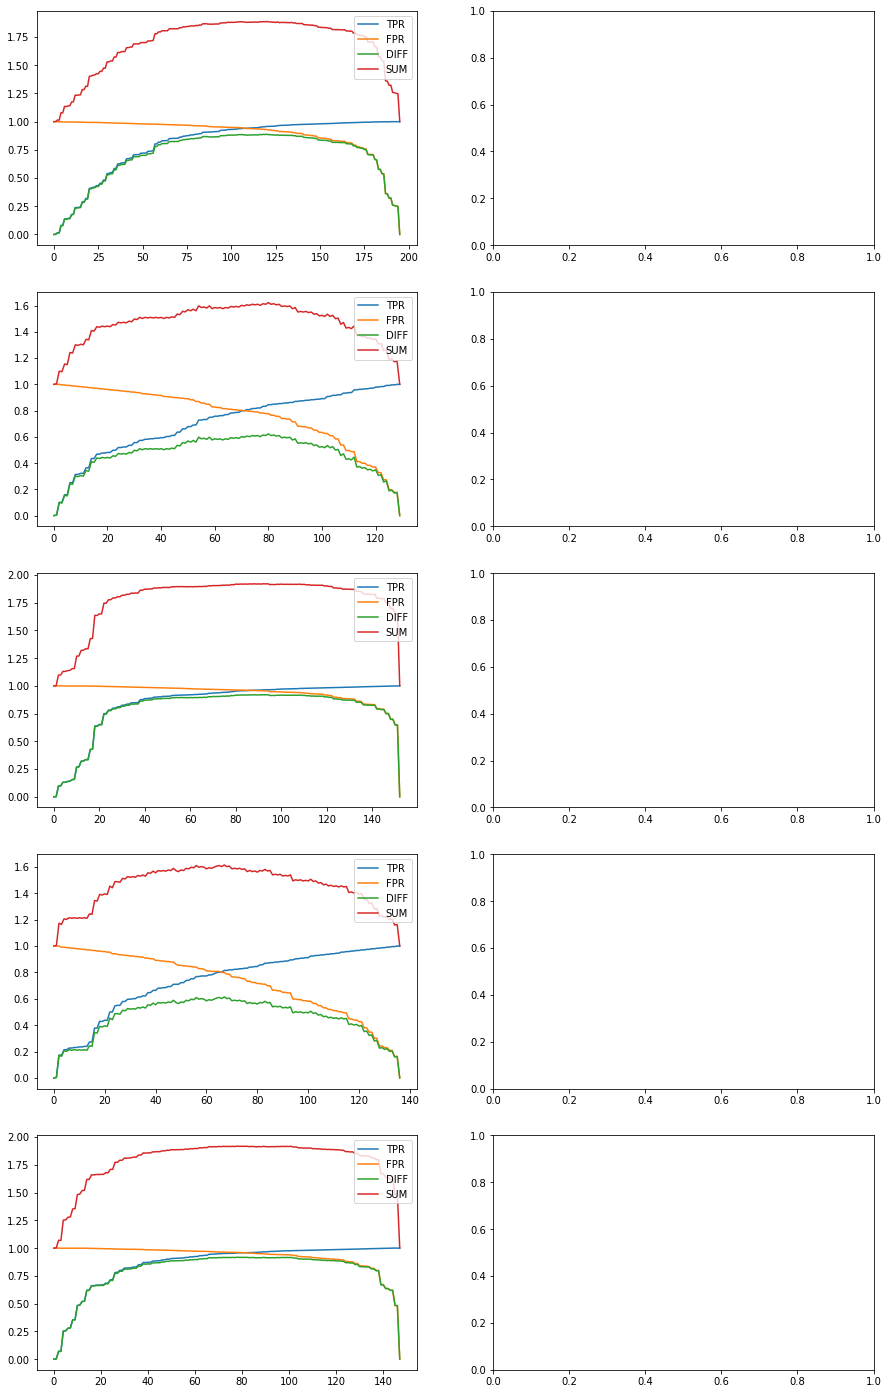

In [19]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(15, 25))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(evaluations_df['TPR'][i])
    axarr[i, 0].plot(1-evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] + (1-evaluations_df['FPR'][i]))
    
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['TPR', 'FPR', 'DIFF', 'SUM'], loc='upper right')
#     axarr[i, 0].show()

#     # "accuracy"
#     title = 'model accuracy '+str(i)
#     axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
# #     axarr[i, 1].title(title)
# #     axarr[i, 1].ylabel('accuracy')
# #     axarr[i, 1].xlabel('epoch')
#     axarr[i, 1].legend(['train', 'validation'], loc='upper right')
# #     axarr[i, 1].show()

# Independent data

In [20]:
train_features = features
train_labels = labels

In [21]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

## Using k-fold Models

### Performance of each k-fold model

In [22]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    indpe_evaluations["Fold"].append(i)
    indpe_evaluations["Train_Test"].append("Independent")
    indpe_evaluations["Accuracy"].append(acc)
    indpe_evaluations["Precision"].append(prec)
    indpe_evaluations["TPR"].append(tpr)
    indpe_evaluations["FPR"].append(fpr)
    indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
    indpe_evaluations["AUC"].append(auc)
    indpe_evaluations["Sensitivity"].append(sens)
    indpe_evaluations["Specificity"].append(spec)
    indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

TypeError: pred2label() missing 1 required positional argument: 'threshold'

In [ ]:
indpe_evaluations_df

### Mean score with k-fold models

In [ ]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

In [ ]:
indpe_evaluations_df

### Voting score with k-fold models

In [ ]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

In [ ]:
indpe_evaluations_df

## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [ ]:
pos_indexes = np.where(indpe_labels==1)[0]
neg_indexes = np.random.permutation(np.where(indpe_labels==0)[0])[0:pos_indexes.shape[0]]
indpe_val_indexes = np.concatenate((pos_indexes, neg_indexes))

In [ ]:
model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
                    batch_size = batch_size, epochs = epochs, 
                    verbose = 1, callbacks = modelCallbacks, 
                    validation_data = (indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

In [ ]:
print(H.history.keys())

# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
print(H.history.keys())

zoom_start, zoom_end = 0, 40

# "Loss"
plt.plot(H.history['loss'][zoom_start:zoom_end])
plt.plot(H.history['val_loss'][zoom_start:zoom_end])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'][zoom_start:zoom_end])
plt.plot(H.history['val_accuracy'][zoom_start:zoom_end])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

In [ ]:
indpe_evaluations_df